In [1]:
import pandas as pd
import numpy as np

from DataPreparation import DataPreparation

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

import matplotlib.pyplot as plt

In [2]:
pics = './images'

In [3]:
df = pd.read_csv('./data/balanced_dataframe.csv', index_col=None)
df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,label
0,10.337455,10.337455,0.057778,-1.272753,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,1
1,10.335047,10.335047,0.059736,-1.271941,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,1
2,10.333078,10.333078,0.061184,-1.271281,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,1
3,10.355554,10.355554,0.205346,-1.235039,0.369988,25.218750,440.504,412.280,440.217203,170,...,0,0,0,0,0,0,0,0,0,1
4,6.090409,6.090409,0.226017,0.226017,0.547921,12.285714,362.614,353.542,360.961752,104,...,0,0,0,0,0,0,0,0,0,1


In [4]:
X = df.drop(columns=['label'])
y = df['label']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=y
                                                    )
# y_test.value_counts()

In [6]:
y_test.shape

(1830,)

In [7]:
data_preparation = DataPreparation(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = data_preparation.clean_dataset()

In [8]:
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix

In [9]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

In [10]:
svc = SVC(random_state=0)

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
param_grid = {'C':[1, 10, 100],
                  'gamma':[0.01,0.001, 'auto', 'scale']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(svc, param_grid, cv=cv, scoring=scoring, refit='AUC', verbose=1, n_jobs=-1)

%time grid.fit(X_train, y_train)

print()
print(grid.best_params_)

y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)

score = roc_auc_score(y_test, y_pred)
print("Mean ROC AUC:", score)

Fitting 30 folds for each of 12 candidates, totalling 360 fits


CPU times: user 1.15 s, sys: 168 ms, total: 1.32 s
Wall time: 1min 44s

{'C': 10, 'gamma': 0.01}
Accuracy: 0.9754098360655737
Mean ROC AUC: 0.9754098360655739


1 122


>1, train: 0.751, test: 0.750
>2, train: 0.858, test: 0.851
>3, train: 0.890, test: 0.878
>4, train: 0.895, test: 0.882
>5, train: 0.906, test: 0.887
>6, train: 0.926, test: 0.913
>7, train: 0.936, test: 0.926
>8, train: 0.940, test: 0.927
>9, train: 0.942, test: 0.936
>10, train: 0.946, test: 0.931
>11, train: 0.952, test: 0.933
>12, train: 0.958, test: 0.939
>13, train: 0.962, test: 0.942
>14, train: 0.964, test: 0.944
>15, train: 0.968, test: 0.949
>16, train: 0.971, test: 0.948
>17, train: 0.975, test: 0.954
>18, train: 0.975, test: 0.957
>19, train: 0.978, test: 0.961
>20, train: 0.980, test: 0.958
>21, train: 0.981, test: 0.962
>22, train: 0.982, test: 0.966
>23, train: 0.982, test: 0.963
>24, train: 0.984, test: 0.964
>25, train: 0.985, test: 0.967
>26, train: 0.985, test: 0.964
>27, train: 0.986, test: 0.966
>28, train: 0.987, test: 0.967
>29, train: 0.988, test: 0.969
>30, train: 0.989, test: 0.968
>31, train: 0.988, test: 0.969
>32, train: 0.988, test: 0.967
>33, train: 0.989

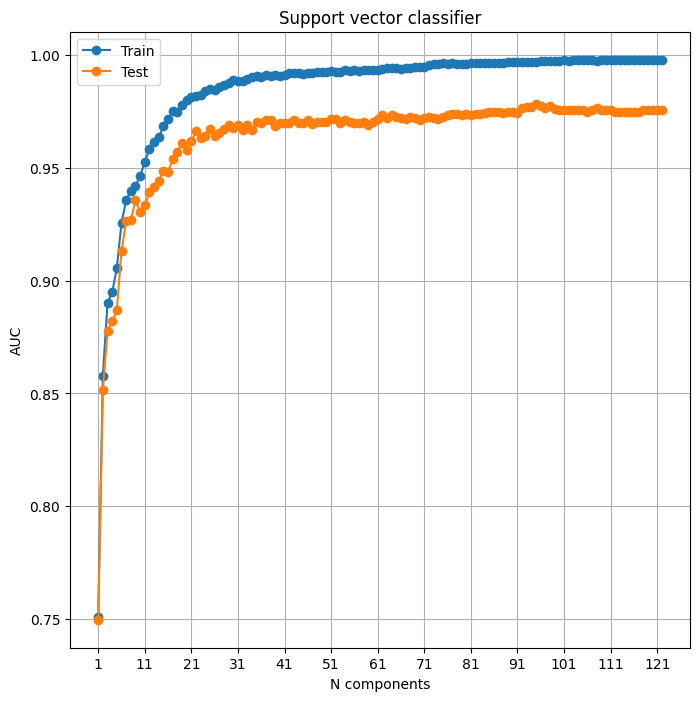

In [11]:
from sklearn.decomposition import PCA

values = [i for i in range(1, X_train.shape[1]+1)]
print(values[0], values[-1])
train_scores = []
test_scores = []

for i in values:
    model = SVC(C=10, gamma=0.01)
    pca = PCA(n_components = i)
    pca_traindata = pca.fit(X_train)

    pcatrain = pca_traindata.transform(X_train)
    pcatest = pca_traindata.transform(X_test)

    model.fit(pcatrain, y_train)
    train_yhat = model.predict(pcatrain)
    train_acc = roc_auc_score(y_train, train_yhat)
    train_scores.append(train_acc)
    
    test_yhat = model.predict(pcatest)
    test_acc = roc_auc_score(y_test, test_yhat)
    test_scores.append(test_acc)

    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
plt.figure(1, figsize=(8,8))
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xticks(range(1, 122, 10))
plt.grid()
plt.title('Support vector classifier')
plt.ylabel('AUC')
plt.xlabel('N components')
# plt.show()
plt.savefig(f'{pics}/clf_dtree_balanced.png')

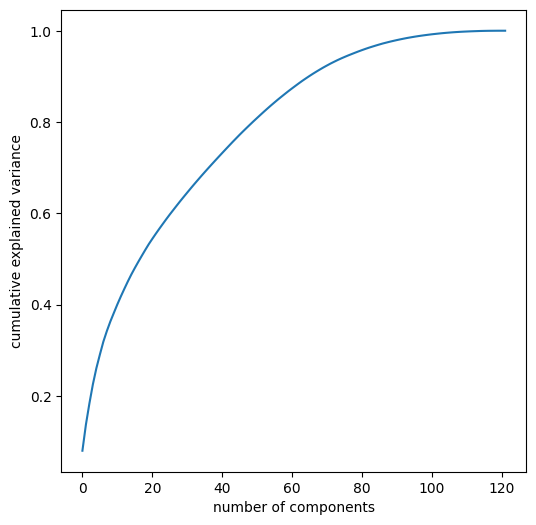

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 122)
pca_traindata = pca.fit(X_train)


pcatrain = pca_traindata.transform(X_train)
pcatest = pca_traindata.transform(X_test)
cum_ratio = (np.cumsum(pca_traindata.explained_variance_ratio_))

fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(cum_ratio)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()
# plt.savefig(f'{pics}/pca.png')

In [22]:
pca = PCA(n_components = 100)
pca_traindata = pca.fit(X_train)


pcatrain = pca_traindata.transform(X_train)
pcatest = pca_traindata.transform(X_test)
cum_ratio = (np.cumsum(pca_traindata.explained_variance_ratio_))

clf = SVC(C=10, gamma=0.01)

clf.fit(pcatrain, y_train)

train_preds = clf.predict(pcatrain)
print(roc_auc_score(y_train, train_preds))
test_preds = clf.predict(pcatest)
print(roc_auc_score(y_test, test_preds))

0.997423887587822
0.9754098360655739


# Permutation feature importance

In [12]:
from sklearn.inspection import permutation_importance

In [14]:
clf = SVC(C=10, gamma=0.01)

clf.fit(X_train, y_train)

result = permutation_importance(clf, X_train, y_train, n_repeats=5, random_state=42, n_jobs=8)
perm_sorted_idx = result.importances_mean.argsort()

In [15]:
train_preds = clf.predict(X_train)
print(roc_auc_score(y_train, train_preds))
test_preds = clf.predict(X_test)
print(roc_auc_score(y_test, test_preds))

0.9976580796252927
0.9754098360655739


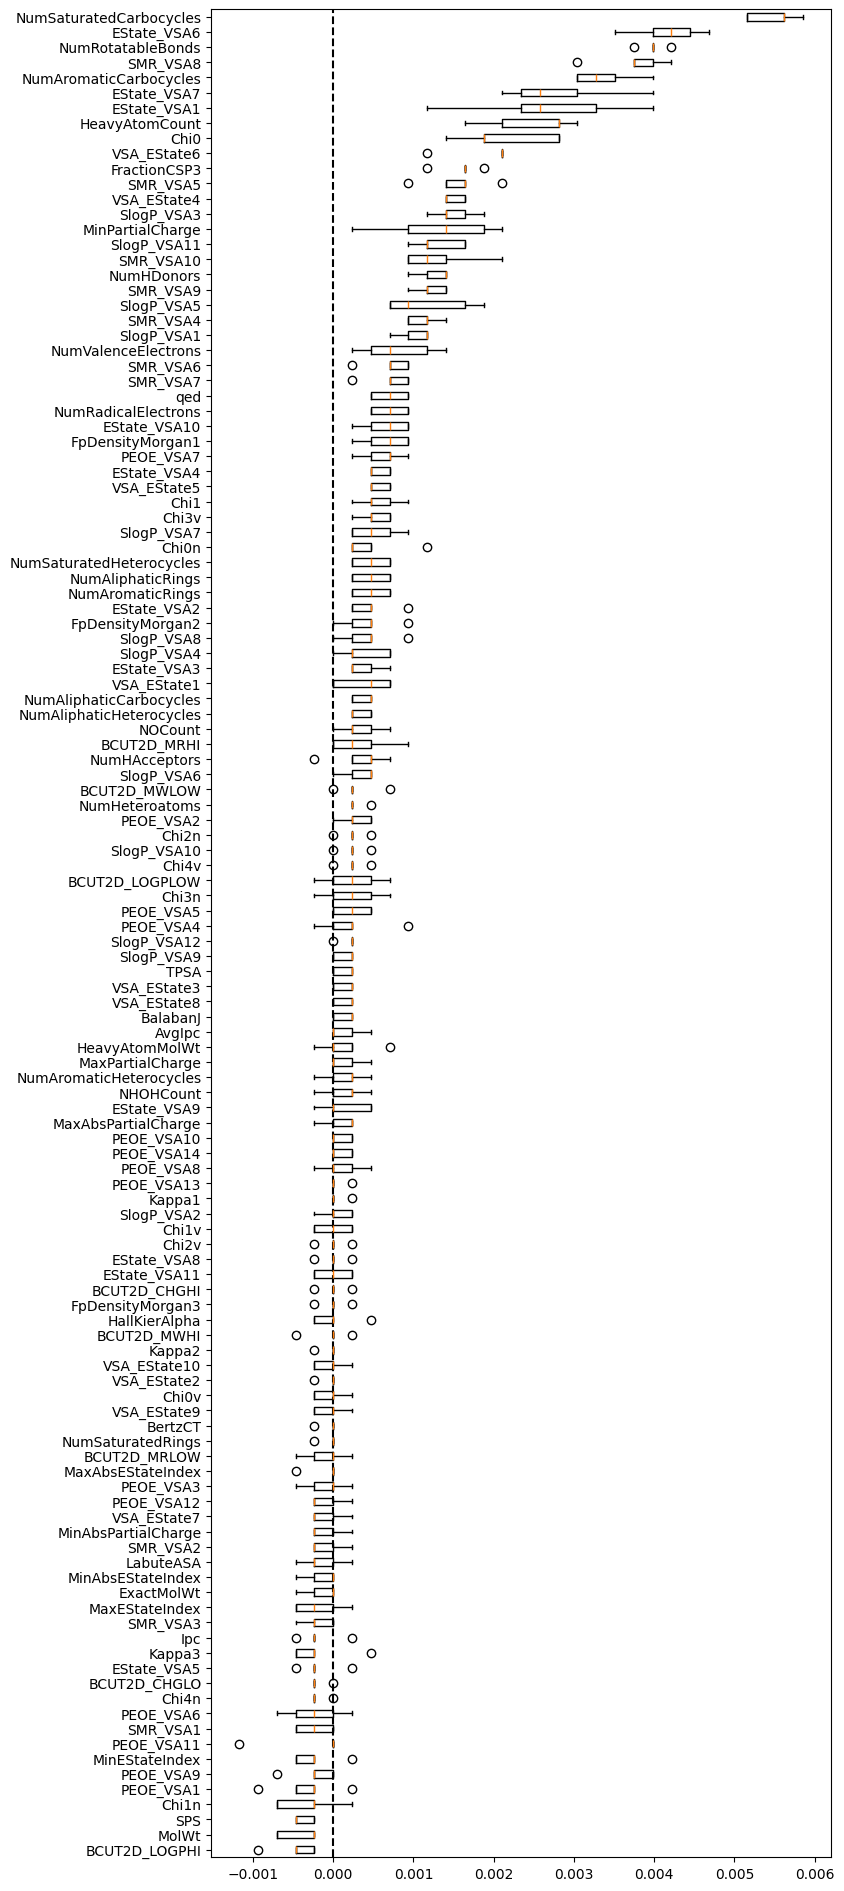

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 24))

ax.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X.columns[perm_sorted_idx],
)
ax.axvline(x=0, color="k", linestyle="--")

In [24]:
clf1 = SVC(C=10, gamma=0.01)
vals = perm_sorted_idx[:15]

clf1.fit(X_train[vals], y_train)

# result = permutation_importance(clf, X_train, y_train, n_repeats=5, random_state=42, n_jobs=8)
# perm_sorted_idx = result.importances_mean.argsort()
# perm_sorted_idx

train_preds = clf1.predict(X_train[vals])
print(roc_auc_score(y_train, train_preds))
test_preds = clf1.predict(X_test[vals])
print(roc_auc_score(y_test, test_preds))

0.9304449648711945
0.9262295081967213


In [30]:
acc_train = []
acc_test = []
num_features = [i for i in range(1, len(perm_sorted_idx + 1))]

for i in num_features:
    clf1 = SVC(C=10, gamma=0.01)
    vals = perm_sorted_idx[:i]
    clf1.fit(X_train[vals], y_train)

# result = permutation_importance(clf, X_train, y_train, n_repeats=5, random_state=42, n_jobs=8)
# perm_sorted_idx = result.importances_mean.argsort()
# perm_sorted_idx
    train_preds = clf1.predict(X_train[vals])
    test_preds = clf1.predict(X_test[vals])
    
    
    

    acc_train.append(roc_auc_score(y_train, train_preds))
    acc_test.append(roc_auc_score(y_test, test_preds))

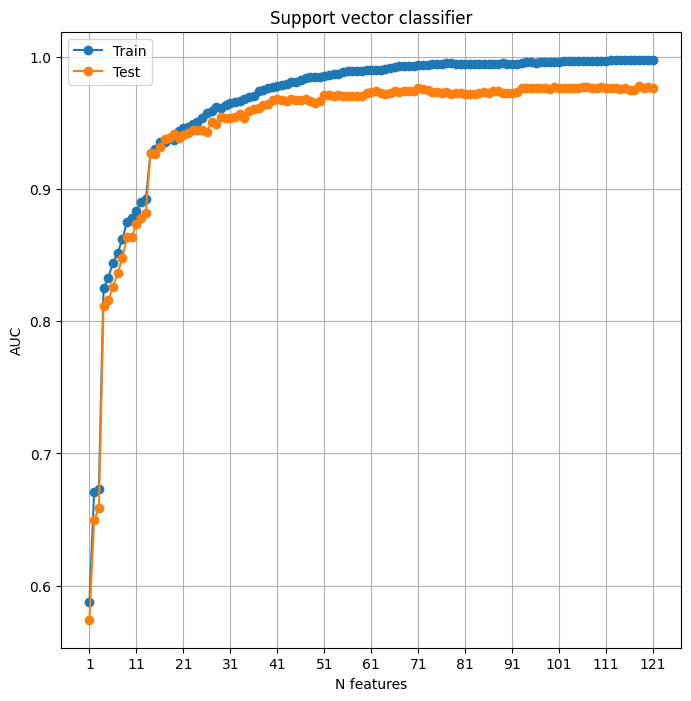

In [32]:
plt.figure(1, figsize=(8,8))
plt.plot(num_features, acc_train, '-o', label='Train')
plt.plot(num_features, acc_test, '-o', label='Test')
plt.legend()
plt.xticks(range(1, 122, 10))
plt.grid()
plt.title('Support vector classifier')
plt.ylabel('AUC')
plt.xlabel('N features')
plt.show()
# plt.savefig(f'{pics}/clf_dtree_balanced.png')

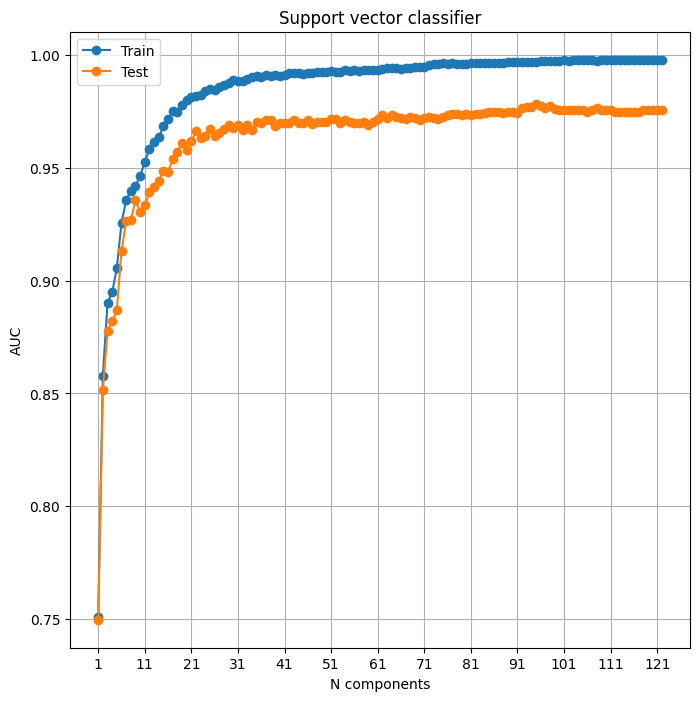

In [33]:
plt.figure(1, figsize=(8,8))
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xticks(range(1, 122, 10))
plt.grid()
plt.title('Support vector classifier')
plt.ylabel('AUC')
plt.xlabel('N components')
# plt.show()
plt.savefig(f'{pics}/clf_dtree_balanced.png')

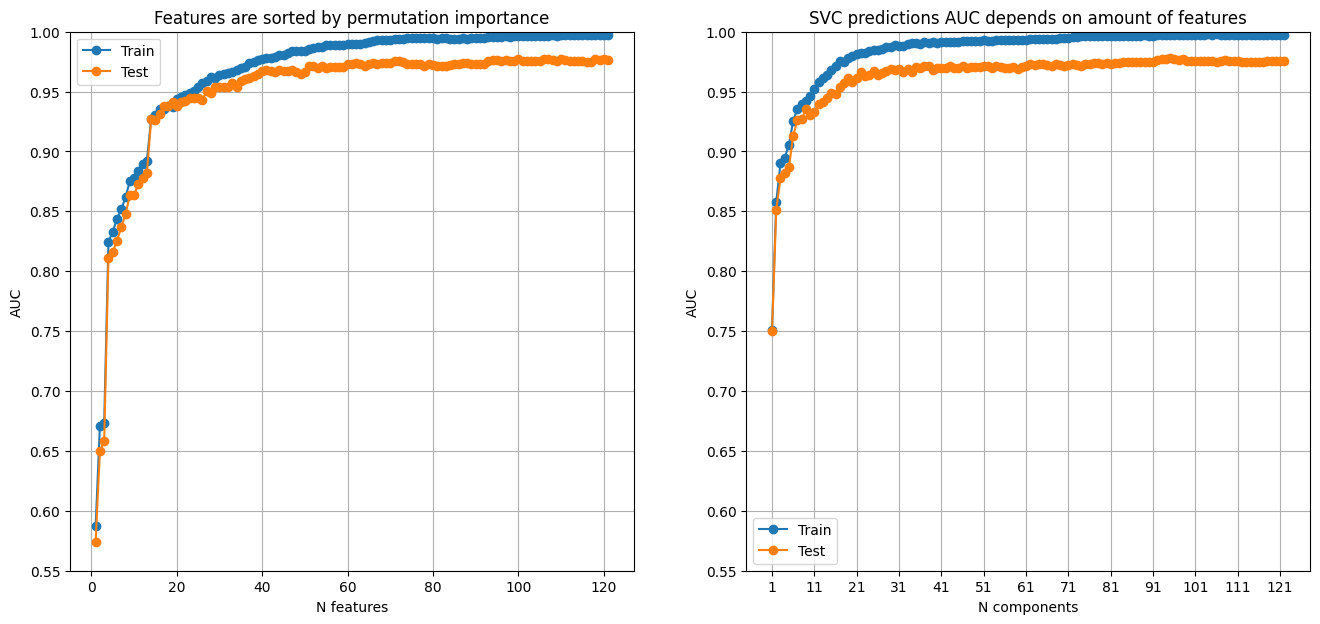

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# ax1.set_xlim(left=0, right=5)
ax1.set_ylim(bottom=0.55, top=1)

ax1.plot(num_features, acc_train, '-o', label='Train')
ax1.plot(num_features, acc_test, '-o', label='Test')
ax1.legend()
plt.xticks(range(1, 122, 10))
ax1.grid()
ax1.set_title('Features are sorted by permutation importance')
ax1.set_ylabel('AUC')
ax1.set_xlabel('N features')

ax2.set_ylim(bottom=0.55, top=1)
ax2.plot(values, train_scores, '-o', label='Train')
ax2.plot(values, test_scores, '-o', label='Test')
ax2.legend()
plt.xticks(range(1, 122, 10))
ax2.grid()
ax2.set_title('PCA')
ax2.set_ylabel('AUC')
ax2.set_xlabel('N components')
# plt.show()
plt.title('SVC predictions AUC depends on amount of features')
plt.savefig(f'{pics}/clf_dtree_balanced.png')